In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from bigfile import BigFile
import glob,os,struct
# from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from scipy.interpolate import interp1d
from colossus.cosmology import cosmology
import seaborn as sns

sns.set()
sns.set_palette("Set2")
sns.set_style('ticks',{'ytick.direction':'in','xtick.direction':'in'})

cmap = plt.get_cmap("Set2")
sns.set_context("paper", font_scale=1.7,rc={"axes.linewidth": 1.3,"lines.linewidth": 2.5,"patch.linewidth": 2.2})
from matplotlib import rcParams as rc
import pickle
import warnings
import h5py

In [2]:
snap = 348
if snap > 294:
    pig = BigFile('/hildafs/datasets/Asterix/PIG2/PIG_%03d'%snap)
else:
    pig = BigFile('/hildafs/datasets/Asterix/PIG_files/PIG_%03d'%snap)

# you can check the redshift by reading the attributes of the snapshot
battr = pig["Header"].attrs
scale_fac = battr["Time"][0]
redshift = 1./battr["Time"][0] - 1
Lbox = battr['BoxSize']
hh = battr['HubbleParam']
om0 = battr['Omega0']
omb = battr['OmegaBaryon']
oml = battr['OmegaLambda']
Nfof = battr['NumFOFGroupsTotal']
sigma8 = 0.82
print('----------PIG file info------------')

print('Redshift = %.2f'%redshift)
print('Lbox = %d ckpc/h'%Lbox)
print('NfofGroups = %d'%Nfof)

print('------cosmological parameters-----')
print('h = %.4f'%hh)
print('Omega_m = %.4f'%om0)
print('Omega_b = %.4f'%omb)
print('Omega_l = %.4f'%oml)


----------PIG file info------------
Redshift = 2.00
Lbox = 250000 ckpc/h
NfofGroups = 186046367
------cosmological parameters-----
h = 0.6774
Omega_m = 0.3089
Omega_b = 0.0486
Omega_l = 0.6911


In [13]:
outdir = '/hildafs/datasets/Asterix/PIG2/PIG_214_subfind'
pig2 = BigFile(outdir)

outdir = '/hildafs/datasets/Asterix/PIG2/PIG_214'
pig = BigFile(outdir)

In [14]:
# the most basic cut on stellar mass and Nbh
ngal = int(1e7) # this is sufficient
nbh = int(1e8)
#------------- Load data ------------------
gal_mass = pig2['SubGroups/SubhaloMassType'][:ngal][:,4] * 1e10/hh
gal_pos = pig2['SubGroups/SubhaloPos'][:ngal]

sublen5 = pig2['SubGroups/SubhaloLenType'][:ngal][:, 5]
mask = gal_mass > 0
mask &= sublen5 > 0
gal_mass = gal_mass[mask]
sublen5 = sublen5[mask]
gal_nbh = sublen5

# Need to touch these fields: SubhaloMassType, SubhaloLenType, SubhaloOffsetType

suboff5 = pig2['SubGroups/SubhaloOffsetType'][:ngal][mask, 5]

ind = mask.nonzero()[0]
print(len(ind))
Ninit = len(ind)


427684


In [11]:
set(sublen5[:800])

{1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 15, 17, 52, 103, 128}

In [16]:
# load BH properties
bhmass = pig2['5/BlackholeMass'][:nbh] * 1e10/hh
bhgroup = pig['5/GroupID'][:nbh] - 1
bhid = pig2['5/ID'][:nbh]

gal_m5 = np.array([np.sum(bhmass[suboff5[i] : suboff5[i] + sublen5[i]]) for i in range(Ninit)])

gal_gidx = np.array([bhgroup[suboff5[i]] for i in range(Ninit)])
gal_cm5 = np.array([np.max(bhmass[suboff5[i] : suboff5[i] + sublen5[i]]) for i in range(Ninit)])
cen_idx = np.array([suboff5[i] + np.argmax(bhmass[suboff5[i] : suboff5[i] + sublen5[i]]) for i in range(Ninit)])


354


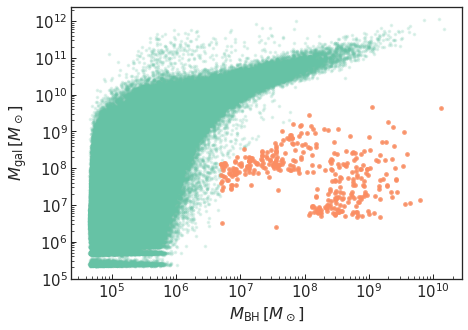

In [23]:
fig, ax = plt.subplots(1,1,figsize=(7,5))

mask1 = gal_cm5 > gal_mass/30
mask1 &= gal_cm5 > 5e6
print(sum(mask1))
# mask2 = (gal_mass > gal_m5 * 5000)
# mask2 &= gal_mass > 1e11 

# mask = ~(mask1 | mask2)

ax.scatter(gal_cm5, gal_mass, s=2, alpha=0.2)
ax.scatter(gal_cm5[mask1], gal_mass[mask1], s=7, alpha=0.8)
# ax.axhline(ms_min, color='grey', linestyle='--', linewidth=1.5)
# ax.axhline(ms_max, color='grey', linestyle='--', linewidth=1.5)

# mask &= gal_mass < ms_max
# mask &= gal_mass > ms_min
# mask &= gal_m5 > mbh_tot_min

# ax.axvline(mbh_tot_min, color='grey', linestyle='--', linewidth=1.5)

# ax.scatter(gal_m5[mask], gal_mass[mask], s=1,color='orange')
ax.set(xscale='log', yscale='log')
# ax.set(xlabel='')
ax.set(xlabel=r'$M_{\rm BH}\,[M_\odot]$', ylabel=r'$M_{\rm gal}\,[M_\odot]$')

plt.show()

In [7]:
BHMass = pig2['5/BlackholeMass'][:]*1e10/hh
bidxlist, = np.where(BHMass > 1e6)

bmass = BHMass[bidxlist]
del BHMass
print(len(bidxlist))

819576


In [ ]:
suboff = pig2['SubGroups/SubhaloOffsetType'][:54000000]
suboff5 = suboff[:,5]
del suboff

In [ ]:
def place(bidxlist,suboff5):
    sidxlist = np.searchsorted(suboff5,bidx,side='right')-1
    return sidxlist

def get_offset(bidxlist,sidxlist):
    centers = pig2['SubGroups/SubhaloPos'][:54000000][sidxlist]
    dpos = pig2['5/Position'][:][bidxlist] - centers
    dpos[dpos > box/2] -= box
    dpos[dpos < -box/2] += box
    return np.linalg.norm(dpos,axis=1)

In [ ]:
box = 250000.
sidxlist = np.searchsorted(suboff5,bidxlist,side='right')-1
print('got sidx')
roff = get_offset(bidxlist,sidxlist)

got sidx


### test code

In [76]:
import numpy as np
from bigfile import BigFile,FileMPI
import h5py
import sys,os
import glob
import argparse
# from bf_util import *
# from mpi4py import MPI


hh = 0.6774

def get_cmbh_mgal(pig2):
    ngal = int(1e7) # this is sufficient
    nbh = int(1e8)
    
    #------------- Load data ------------------
    gal_mass = pig2['SubGroups/SubhaloMassType'][:ngal][:,4] * 1e10/hh
    sublen5 = pig2['SubGroups/SubhaloLenType'][:ngal][:, 5]
    mask = gal_mass > 0
    mask &= sublen5 > 0
    gal_mass = gal_mass[mask]
    sublen5 = sublen5[mask]
    suboff5 = pig2['SubGroups/SubhaloOffsetType'][:ngal][mask, 5]

    ind = mask.nonzero()[0]
    Ninit = len(ind)

    # load BH properties
    bhmass = pig2['5/BlackholeMass'][:nbh] * 1e10/hh
    gal_cm5 = np.array([np.max(bhmass[suboff5[i] : suboff5[i] + sublen5[i]]) for i in range(Ninit)])
    
    bhgroup = pig2['5/GroupID'][:nbh] - 1
    gal_gidx = np.array([bhgroup[suboff5[i]] for i in range(Ninit)])
    
    cen_idx = np.array([suboff5[i] + np.argmax(bhmass[suboff5[i] : suboff5[i] + sublen5[i]]) for i in range(Ninit)])
    
    
    return gal_gidx, gal_cm5, gal_mass, cen_idx, ind
    


def get_targets(gal_gidx, gal_cm5, gal_mass, cen_idx, ind):

    # group index, central BH mass, central BH index for each galaxy
    
    
    # reassign these BHs:
    mask1 = gal_cm5 > gal_mass/10
    mask1 &= gal_cm5 > 2e7
    
    gidx_tar = gal_gidx[mask1]
    sidx_tar = ind[mask1]
    bidx_tar = cen_idx[mask1]
    print(gidx_tar[:10])
    print(sidx_tar[:10])
    

    return gidx_tar, sidx_tar, bidx_tar


def calc_dr(cen_pos, bhpos):
    dpos = cen_pos - bhpos
    lbox = 250000.
    dpos[dpos > lbox/2] -= lbox
    dpos[dpos < -lbox/2] += lbox
    dr = np.linalg.norm(dpos, axis=1)
    return dr


def rewrite_bh_data(pig2, gidx, sidx, bidx):
    gobt = pig2['FOFGroups/OffsetByType']
    glbt = pig2['FOFGroups/LengthByType']
    
    nmax = int(1e7)
    spos = pig2['SubGroups/SubhaloPos']
    smass = pig2['SubGroups/SubhaloMassType']
    
    sobt = pig2['SubGroups/SubhaloOffsetType'][:nmax]
    slbt = pig2['SubGroups/SubhaloLenType'][:nmax]
    
    # we redo mass later
    
    gstart, gend = gobt[gidx][5], gobt[gidx][5] + glbt[gidx][5]
    firstsub = pig2['FOFGroups/GroupFirstSub'][gidx]
    nsub = pig2['FOFGroups/GroupNsubs'][gidx]
    
    sstarts = sobt[firstsub : firstsub + nsub]
    cen_pos = spos[firstsub : firstsub + nsub]
    bh_pos = pig2['5/Position'][bidx]
    bgroup = pig2['5/GroupID'][bidx] - 1
    bmass = pig2['5/BlackholeMass'][bidx] * 1e10/hh
    
    #--------------------Find new order----------------------------
    order = np.arange(0, glbt[gidx][5])
    idx_in_group = int(bidx - gstart)
    dr = calc_dr(cen_pos, bh_pos)

    for i,d in enumerate(dr):
        if d < 20:
            break
    insert = int(sstarts[i][5] - sstarts[0][5])
    newsub = i + firstsub
    print('BH with mass %.1e will be reassigned to subgroup %d with separation %.1f ckpc/h, mass %.1e'\
          %(bmass, i, d, smass[newsub][4]*1e10/hh), flush=True)
    
    print(insert, idx_in_group)
    
    order[insert], order[insert+1 : idx_in_group+1] = idx_in_group, order[insert : idx_in_group]
    
    #--------------------------------------------------------------
    print('Reordering BHs in group...', flush=True)
    # write re-ordered data
    
    
    #--------------------------------------------------------------
    print('Rewriting Length and Offset of BHs...', flush=True)
    slbt_group = pig2['SubGroups/SubhaloLenType'][firstsub : firstsub + nsub]
    slen_group = pig2['SubGroups/SubhaloLen'][firstsub : firstsub + nsub]
    slbt_group[sidx - firstsub, 5] -= 1
    slen_group[sidx - firstsub] -= 1
    slbt_group[i, 5] += 1
    slen_group[i] += 1
    
    sobt_group = np.zeros_like(slbt_group)
    sobt_group[1:] = np.cumsum(slbt_group[:-1], axis=0)
    
    print(order)

    for ff in glob.glob(outdir + '/5/*'):
        blockname = ff.split('/')[-1]
        data = pig2['5/%s'%blockname][gstart:gend]
        data = data[order]
        
        if blockname=='Position':

            start, end = sobt_group[i][5], sobt_group[i][5] + slbt_group[i][5]
            dd = data[start:end]
            
            plt.scatter(dd[:,0] - bh_pos[0], dd[:,1] - bh_pos[1])
            plt.xlim([-30,30])
            plt.ylim([-30,30])

            plt.show()
        
        
            
        # pig2['5/%s'%blockname].write(start,data)
        

    
    
    
    # slbt[firstsub:firstsub+nsub] = slbt_group
    # sobt[firstsub:firstsub+nsub] = sobt_group
    # slen[firstsub:firstsub+nsub] = slen_group
    
#     pig2['SubGroups/SubhaloLenType'].write(firstsub, slbt_group)
#     pig2['SubGroups/SubhaloLen'].write(firstsub, slen_group)
#     pig2['SubGroups/SubhaloOffsetType'].write(firstsub, sobt_group)
    
    
    print('done with group %d, subgroup %d, blackhole idx %d'%(gidx, sidx, bidx), flush=True)
    
    new_sidx = firstsub + i
    return new_sidx

[0 0 1 2 3 5 6 6 7 9]
[  147  4669  9143 12967 16596 23806 26923 28956 30743 33613]
530


[Text(0.5, 0, '$M_{\\rm BH}\\,[M_\\odot]$')]

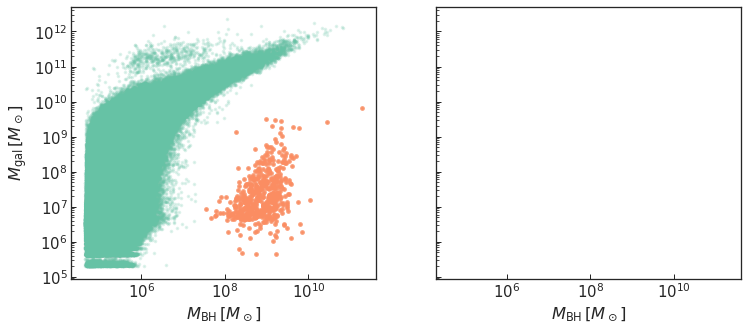

In [74]:
snap = 348
outdir = '/hildafs/datasets/Asterix/PIG2/PIG_%03d_subfind'%(snap)
pig2 = BigFile(outdir)



gal_gidx, gal_cm5, gal_mass, cen_idx, ind = get_cmbh_mgal(pig2)

gidx_tar, sidx_tar, bidx_tar = get_targets(gal_gidx, gal_cm5, gal_mass, cen_idx, ind)

print(len(gidx_tar))

fig, ax = plt.subplots(1,2,figsize=(12,5), sharex=True, sharey=True)

mask1 = gal_cm5 > gal_mass/10
mask1 &= gal_cm5 > 2e7
ax[0].scatter(gal_cm5, gal_mass, s=2, alpha=0.2, color=cmap(0))
ax[0].scatter(gal_cm5[mask1], gal_mass[mask1], s=7, alpha=0.8, color=cmap(1))
ax[0].set(xscale='log', yscale='log')
ax[0].set(xlabel=r'$M_{\rm BH}\,[M_\odot]$', ylabel=r'$M_{\rm gal}\,[M_\odot]$')
ax[1].set(xlabel=r'$M_{\rm BH}\,[M_\odot]$')





0 147 1591
BH with mass 2.8e+10 will be reassigned to subgroup 1 with separation 0.2 ckpc/h, mass 1.4e+12
789 1591
Reordering BHs in group...
Rewriting Length and Offset of BHs...
[   0    1    2 ... 3168 3169 3170]


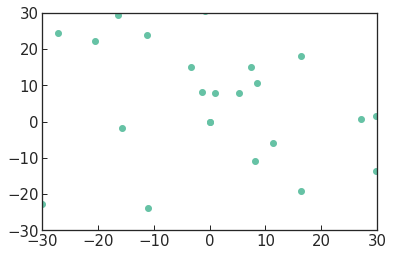

done with group 0, subgroup 147, blackhole idx 1591
0 4669 3051
BH with mass 2.2e+08 will be reassigned to subgroup 35 with separation 1.7 ckpc/h, mass 7.5e+10
1370 3051
Reordering BHs in group...
Rewriting Length and Offset of BHs...
[   0    1    2 ... 3168 3169 3170]


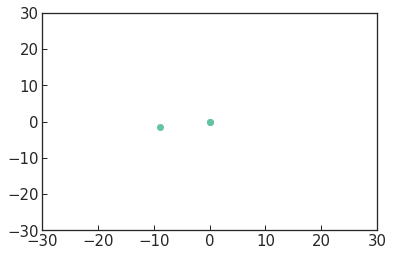

done with group 0, subgroup 4669, blackhole idx 3051
1 9143 4520
BH with mass 2.1e+09 will be reassigned to subgroup 1 with separation 0.7 ckpc/h, mass 4.7e+11
531 1349
Reordering BHs in group...
Rewriting Length and Offset of BHs...
[   0    1    2 ... 1712 1713 1714]


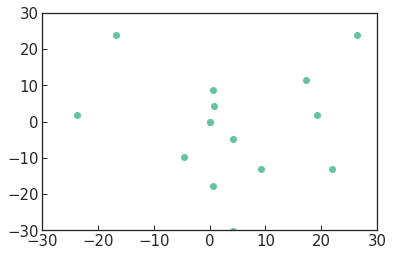

done with group 1, subgroup 9143, blackhole idx 4520


In [77]:
new_sidx_list = []
for gidx, sidx, bidx in zip(gidx_tar[:3], sidx_tar[:3], bidx_tar[:3]):
    print(gidx, sidx, bidx)
    new = rewrite_bh_data(pig2, gidx, sidx, bidx)
    new_sidx_list.append(new)


# # plot again to check

# gal_gidx, gal_cm5, gal_mass, cen_idx, ind = get_cmbh_mgal(pig2)

# smbt = pig2['SubGroups/SubhaloMassType']
# bmass = pig2['5/BlackholeMass']
# gal_sel = [smbt[snew][4] * 1e10/hh for snew in new_sidx_list]
# gal_cm5_sel = [np.max(bhmass[suboff5[i] : suboff5[i] + sublen5[i]]) for i in new_sidx_list]

# ax[1].scatter(gal_cm5, gal_mass, s=2, alpha=0.2, color=cmap(0))
# ax[1].scatter(gal_cm5_sel, gal_sel, s=7, alpha=0.8, color=cmap(1))


# print('done!', flush=True)

In [64]:



def scatter_positions(gidx, sidx, bidx, newsub):
    og, lg = pig2['FOFGroups/OffsetByType'][gidx], pig2['FOFGroups/LengthByType'][gidx]

    osub, lsub = pig2['SubGroups/SubhaloOffsetType'][sidx], pig2['SubGroups/SubhaloLenType'][sidx]
    gbeg, gend = og, og + lg
    sbeg, send = osub, osub + lsub
    snew = pig2['FOFGroups/GroupFirstSub'][gidx] + newsub
    
    nbeg, nend = pig2['SubGroups/SubhaloOffsetType'][snew], pig2['SubGroups/SubhaloOffsetType'][snew] + pig2['SubGroups/SubhaloLenType'][snew]
    
    pos5_tar = pig2['5/Position'][bidx]
    
    
    
    sfirst, slast = pig2['FOFGroups/GroupFirstSub'][gidx], pig2['FOFGroups/GroupFirstSub'][gidx] + pig2['FOFGroups/GroupNsubs'][gidx]
    
    com = pig2['SubGroups/SubhaloCM'][sfirst : slast] - pos5_tar 
    minpos = pig2['SubGroups/SubhaloPos'][sfirst : slast] - pos5_tar 

    pos4_group = pig2['4/Position'][gbeg[4] : gend[4]] - pos5_tar
    pos5_group = pig2['5/Position'][gbeg[5] : gend[5]] - pos5_tar

    pos4_sub = pig2['4/Position'][sbeg[4] : send[4]] - pos5_tar
    pos5_sub = pig2['5/Position'][sbeg[5] : send[5]] - pos5_tar
    
    
    pos4_new = pig2['4/Position'][nbeg[4] : nend[4]] - pos5_tar
    

    print(len(pos4_sub))
    fig, ax = plt.subplots(1,2,figsize=(10,5), sharex=True, sharey=True)
    # ax[0].scatter(pos4_group[:,0], pos4_group[:,1], s=0.01)
    ax[0].scatter(pos4_sub[:,0], pos4_sub[:,1], s=20)
    ax[0].scatter(pos4_new[:,0], pos4_new[:,1], s=20)
    ax[0].scatter(com[:,0], com[:,1], s=50, marker='x', color='k')
    ax[0].scatter(pos5_sub[:,0], pos5_sub[:,1], s=100, marker='x', color='r')
    # ax[0].scatter(minpos[:,0], minpos[:,1], s=100, marker='x', color='r')

    # ax[1].scatter(pos4_group[:,2], pos4_group[:,1], s=0.01)
    ax[1].scatter(pos4_sub[:,2], pos4_sub[:,1], s=20)
    ax[1].scatter(com[:,2], com[:,1], s=50, marker='x', color='k')
    ax[1].scatter(pos5_sub[:,2], pos5_sub[:,1], s=100, marker='x', color='r')
    
    lbox = 50
    ax[1].set(xlim=[-lbox, lbox], ylim=[-lbox, lbox])
    
    plt.show()



13


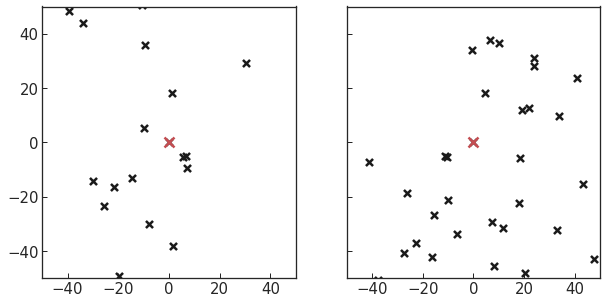

In [57]:
#done with group 9, subgroup 33613, blackhole idx 13825
gidx = 9 
sidx = 35790
bidx = 14135
newsub = 2130

scatter_positions(gidx, sidx, bidx, newsub)

In [15]:
outdir = '/hildafs/datasets/Asterix/PIG2/PIG_348_subfind'
pig_r = BigFile(outdir)

In [52]:
hh = 0.6774

def get_cmbh_mgal(pig2):
    ngal = int(1e7) # this is sufficient
    nbh = int(1e8)
    
    #------------- Load data ------------------
    gal_mass = pig2['SubGroups/SubhaloMassType'][:ngal][:,4] * 1e10/hh
    sublen5 = pig2['SubGroups/SubhaloLenType'][:ngal][:, 5]
    mask = gal_mass > 0
    mask &= sublen5 > 0
    gal_mass = gal_mass[mask]
    sublen5 = sublen5[mask]
    suboff5 = pig2['SubGroups/SubhaloOffsetType'][:ngal][mask, 5]

    ind = mask.nonzero()[0]
    Ninit = len(ind)

    # load BH properties
    bhmass = pig2['5/BlackholeMass'][:nbh] * 1e10/hh
    gal_cm5 = np.array([np.max(bhmass[suboff5[i] : suboff5[i] + sublen5[i]]) for i in range(Ninit)])
    
    bhgroup = pig2['5/GroupID'][:nbh] - 1
    gal_gidx = np.array([bhgroup[suboff5[i]] for i in range(Ninit)])
    
    cen_idx = np.array([suboff5[i] + np.argmax(bhmass[suboff5[i] : suboff5[i] + sublen5[i]]) for i in range(Ninit)])
    return gal_gidx, gal_cm5, gal_mass, cen_idx, ind
    


def get_targets(gal_gidx, gal_cm5, gal_mass, cen_idx, ind):

    # reassign these BHs:
    mask1 = gal_cm5 > gal_mass/10
    mask1 &= gal_cm5 > 2e7
    
    gidx_tar = gal_gidx[mask1]
    sidx_tar = ind[mask1]
    bidx_tar = cen_idx[mask1]
    # print(gidx_tar[:10])
    # print(sidx_tar[:10])
    return gidx_tar, sidx_tar, bidx_tar


def calc_dr(cen_pos, bhpos):
    dpos = cen_pos - bhpos
    lbox = 250000.
    dpos[dpos > lbox/2] -= lbox
    dpos[dpos < -lbox/2] += lbox
    dr = np.linalg.norm(dpos, axis=1)
    return dr


def process_group(pig_r, gidx):
    
    gstart, gend = int(Gobt[gidx][5]), int(Gobt[gidx][5] + Glbt[gidx][5]) # abs start, end index of BH in this group
    firstsub = int(FirstSub[gidx])
    nsub = int(Nsub[gidx])
    print(nsub)
    
    sobt    = Sobt[firstsub : firstsub + nsub] # start index of all part in each subgroup
    slbt    = Slbt[firstsub : firstsub + nsub]
    slen    = pig_r['SubGroups/SubhaloLen'][firstsub : firstsub + nsub]
    cen_pos = Spos[firstsub : firstsub + nsub] # position of each subgroup
    allbh_mass = pig_r['5/BlackholeMass'][gstart:gend]*1e10/hh
    
    
    # the original index of all bhs in this group
    allbh_sidx = np.zeros(Glbt[gidx][5], dtype=int)
    
    cbh_mass_list = []
    gal_mass_list = []
    for nn in range(nsub):
        beg, end = int(sobt[nn][5] - gstart), int(sobt[nn][5] - gstart + slbt[nn][5])
        allbh_sidx[beg : end] = nn
        if slbt[nn][5] > 0:
            cbh_mass_list.append(np.max(allbh_mass[beg: end]))
            gal_mass_list.append(Smbt[nn+firstsub][4]*1e10/hh)
        
    allbh_sidx[end:] = 100000000
    
    # print(allbh_sidx)
    print('BHs to reassign in this group:',  len(groups[gidx]), flush=True)
    
    for sidx, bidx in groups[gidx]:
        bhpos   = pig_r['5/Position'][bidx]
        bhgroup = pig_r['5/GroupID'][bidx] - 1
        bhmass  = pig_r['5/BlackholeMass'][bidx] * 1e10/hh
        #--------------------Find new order----------------------------
        idx_in_group = int(bidx - gstart) # bh index in group
        dr = calc_dr(cen_pos, bhpos)

        for i,d in enumerate(dr):
            if d < 30:
                break
        newsub = i + firstsub # abs index of new subgroup
        print('BH with mass %.1e will be reassigned to subgroup %d with separation %.1f ckpc/h, mass %.1e'\
              %(bhmass, i, d, Smbt[newsub][4]*1e10/hh), flush=True)
        bhmass_list.append(bhmass)
        smass_list.append(Smbt[newsub][4]*1e10/hh)
        
        allbh_sidx[bidx - gstart] = i
        
#         print(allbh_sidx)
#         print(slbt[:,5], sobt[:,5])
        
        slbt[sidx - firstsub][5] -= 1
        slen[sidx - firstsub] -= 1
        slbt[i][5] += 1
        slen[i] += 1
        

    # this is the new order of BHs in this group
    order = np.argsort(allbh_sidx)

    sobt = np.zeros(slbt.shape, dtype=np.int64)
    sobt[1:] = np.cumsum(slbt[:-1], axis=0)
    sobt += Sobt[firstsub]
    
    print(slbt[:,5], sobt[:,5])
    
#     print(gstart, sobt[0])
#     print(allbh_sidx)
#     print(order)
    
    return order, sobt, slbt, slen, cbh_mass_list, gal_mass_list

In [75]:
pig_r = BigFile('/hildafs/datasets/Asterix/PIG2/PIG_348_subfind')

Gobt = pig_r['FOFGroups/OffsetByType']
Glbt = pig_r['FOFGroups/LengthByType']

Sobt = pig_r['SubGroups/SubhaloOffsetType']
Slbt = pig_r['SubGroups/SubhaloLenType']

Spos = pig_r['SubGroups/SubhaloPos']
Smbt = pig_r['SubGroups/SubhaloMassType']

FirstSub = pig_r['FOFGroups/GroupFirstSub']
Nsub     = pig_r['FOFGroups/GroupNsubs']



# gal_gidx, gal_cm5, gal_mass, cen_idx, ind = get_cmbh_mgal(pig_r)
# gidx_tar, sidx_tar, bidx_tar = get_targets(gal_gidx, gal_cm5, gal_mass, cen_idx, ind)


# # group by gidx
# groups = {}
# for gidx, sidx, bidx in zip(gidx_tar, sidx_tar, bidx_tar):
#     if gidx in groups:
#         groups[gidx].append((sidx, bidx))
#     else:
#         groups[gidx] = [(sidx, bidx)]


In [76]:
bhmass_list = []
smass_list = []
gidx = 19
print(gidx)
order, sobt, slbt, slen, cbh_mass_list, gal_mass_list = process_group(pig_r, gidx)

19
1777
BHs to reassign in this group: 1
BH with mass 6.1e+09 will be reassigned to subgroup 0 with separation 0.2 ckpc/h, mass 1.2e+12
[237  19  19 ...   1   0   0] [21595 21832 21851 ... 22310 22311 22311]


In [77]:
len(gal_mass_list)

395

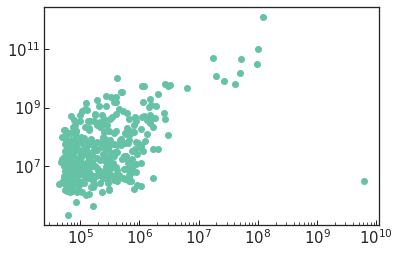

In [78]:
plt.scatter(cbh_mass_list, gal_mass_list)
plt.xscale('log')
plt.yscale('log')

1777
BHs to reassign in this group: 1
BH with mass 3.1e+05 will be reassigned to subgroup 1477 with separation 2.4 ckpc/h, mass 1.3e+06
[237  19  19 ...   1   0   0] [21595 21832 21851 ... 22310 22311 22311]


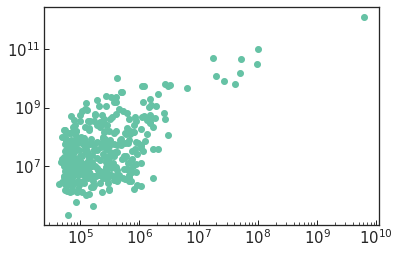

In [79]:
pig_r = BigFile('/hildafs/datasets/Asterix/PIG2/PIG_348_test')

Gobt = pig_r['FOFGroups/OffsetByType']
Glbt = pig_r['FOFGroups/LengthByType']

Sobt = pig_r['SubGroups/SubhaloOffsetType']
Slbt = pig_r['SubGroups/SubhaloLenType']

Spos = pig_r['SubGroups/SubhaloPos']
Smbt = pig_r['SubGroups/SubhaloMassType']

FirstSub = pig_r['FOFGroups/GroupFirstSub']
Nsub     = pig_r['FOFGroups/GroupNsubs']



bhmass_list = []
smass_list = []

order, sobt, slbt, slen, cbh_mass_list, gal_mass_list = process_group(pig_r, gidx)

plt.scatter(cbh_mass_list, gal_mass_list)
plt.xscale('log')
plt.yscale('log')

In [59]:
pig_r = BigFile('/hildafs/datasets/Asterix/PIG2/PIG_348_test')

In [60]:
Gobt = pig_r['FOFGroups/OffsetByType']
Glbt = pig_r['FOFGroups/LengthByType']

Sobt = pig_r['SubGroups/SubhaloOffsetType']
Slbt = pig_r['SubGroups/SubhaloLenType']

Spos = pig_r['SubGroups/SubhaloPos']
Smbt = pig_r['SubGroups/SubhaloMassType']

FirstSub = pig_r['FOFGroups/GroupFirstSub']
Nsub     = pig_r['FOFGroups/GroupNsubs']



# gal_gidx, gal_cm5, gal_mass, cen_idx, ind = get_cmbh_mgal(pig_r)
# gidx_tar, sidx_tar, bidx_tar = get_targets(gal_gidx, gal_cm5, gal_mass, cen_idx, ind)


# # group by gidx
# groups = {}
# for gidx, sidx, bidx in zip(gidx_tar, sidx_tar, bidx_tar):
#     if gidx in groups:
#         groups[gidx].append((sidx, bidx))
#     else:
#         groups[gidx] = [(sidx, bidx)]


In [61]:
bhmass_list = []
smass_list = []
gidx = list(groups.keys())[14]
print(gidx)
order, sobt, slbt, slen, cbh_mass_list, gal_mass_list = process_group(pig_r, gidx)

26
2138
BHs to reassign in this group: 2
BH with mass 2.5e+05 will be reassigned to subgroup 1161 with separation 3.1 ckpc/h, mass 2.4e+06
BH with mass 7.8e+04 will be reassigned to subgroup 1581 with separation 6.3 ckpc/h, mass 3.1e+06
[100  76  39 ...   1   0   0] [26479 26579 26655 ... 27178 27179 27179]


## sanity checks for snap348

In [81]:
outdir = '/hildafs/datasets/Asterix/PIG2/PIG_348_test'
pig2 = BigFile(outdir)



In [82]:
# the most basic cut on stellar mass and Nbh
ngal = int(1e7) # this is sufficient
nbh = int(1e8)
#------------- Load data ------------------
gal_mass = pig2['SubGroups/SubhaloMassType'][:ngal][:,4] * 1e10/hh
gal_pos = pig2['SubGroups/SubhaloPos'][:ngal]

sublen5 = pig2['SubGroups/SubhaloLenType'][:ngal][:, 5]
mask = gal_mass > 0
mask &= sublen5 > 0
gal_mass = gal_mass[mask]
sublen5 = sublen5[mask]
gal_nbh = sublen5

# Need to touch these fields: SubhaloMassType, SubhaloLenType, SubhaloOffsetType

suboff5 = pig2['SubGroups/SubhaloOffsetType'][:ngal][mask, 5]

ind = mask.nonzero()[0]
print(len(ind))
Ninit = len(ind)


2115939


In [83]:
# load BH properties
bhmass = pig2['5/BlackholeMass'][:nbh] * 1e10/hh
bhgroup = pig2['5/GroupID'][:nbh] - 1
bhid = pig2['5/ID'][:nbh]

gal_m5 = np.array([np.sum(bhmass[suboff5[i] : suboff5[i] + sublen5[i]]) for i in range(Ninit)])

gal_gidx = np.array([bhgroup[suboff5[i]] for i in range(Ninit)])
gal_cm5 = np.array([np.max(bhmass[suboff5[i] : suboff5[i] + sublen5[i]]) for i in range(Ninit)])
cen_idx = np.array([suboff5[i] + np.argmax(bhmass[suboff5[i] : suboff5[i] + sublen5[i]]) for i in range(Ninit)])


3


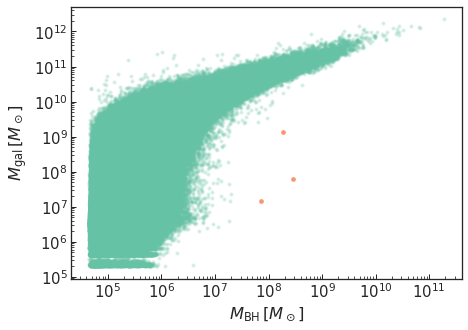

In [84]:
fig, ax = plt.subplots(1,1,figsize=(7,5))

mask1 = gal_cm5 > gal_mass/10
mask1 &= gal_cm5 > 2e7
print(sum(mask1))
# mask2 = (gal_mass > gal_m5 * 5000)
# mask2 &= gal_mass > 1e11 

# mask = ~(mask1 | mask2)

ax.scatter(gal_cm5, gal_mass, s=4, alpha=0.2)
ax.scatter(gal_cm5[mask1], gal_mass[mask1], s=7, alpha=0.8)


tar = mask1.nonzero()[0][:]
mask = gal_gidx[tar]==19

ax.scatter(gal_cm5[tar][mask], gal_mass[tar][mask], s=7, alpha=0.8)



# ax.scatter(gal_m5[mask], gal_mass[mask], s=1,color='orange')
ax.set(xscale='log', yscale='log')
# ax.set(xlabel='')
ax.set(xlabel=r'$M_{\rm BH}\,[M_\odot]$', ylabel=r'$M_{\rm gal}\,[M_\odot]$')

plt.show()

In [85]:
tar = mask1.nonzero()[0][:]
gal_gidx[tar]


array([ 31,  41, 253], dtype=uint32)

In [12]:
suboff5[tar]

array([ 1227,  1413,  5590,  9657, 13734, 20446, 21926, 21967, 21992,
       23415])

In [155]:
sublen5[tar]

array([17,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1], dtype=int32)